# Probabilistic Autoencode on LHCO data

## Import machine lerning libraries

In [1]:
import sys
import numpy as np
import pandas as pd

sys.path.append("../")

from pae.models.autoencoder import DenseAutoencoder
from pae.models.flows import MAF
from pae.models.nn import PaeBuilder

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as tfk

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


2022-02-28 12:11:09.051999: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-28 12:11:10.396885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: NVIDIA Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-02-28 12:11:10.398547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30538 MB memory:  -> device: 1, name: NVIDIA Tesla V100S-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [3]:
from tensorflow.python.client import device_lib

devices = tf.config.list_physical_devices()
print("tensorflow", tf.__version__)
print("tensorflow-probability", tfp.__version__)
print("Available devices:", *[dev[1] for dev in devices])

SEED = 42
np.random.seed(SEED) 
tf.random.set_seed(SEED)

tensorflow 2.6.0
tensorflow-probability 0.14.0
Available devices: CPU GPU GPU


## Plotting libraries 

In [4]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected = True)
pio.templates.default = "plotly_dark"


## Data loading and preprocessing

In [5]:
from pae.utils import load_json, dump_json

from pae.loaders.LHCO import ScalarLoaderLHCO, ImageLoaderLHCO, DatasetBuilder

x = ImageLoaderLHCO.from_json("../pae/configs/loader/images_rnd.json")
mjj = ScalarLoaderLHCO.from_json("../pae/configs/loader/rnd_scalar_mjj.json")
builder = DatasetBuilder(x, mjj)
builder.data_preparation(sample_sizes ={'sig':5_000, 'bkg': 600_000}, fit_key='bkg')
dataset = builder.make_dataset(train = {'bkg':500_000}, test={'sig':5_000, 'bkg': 100_000}, shuffle=True, validation_split=0.2)

## Network creation

In [6]:
print(dataset.keys())

dict_keys(['mjj_train', 'mjj_test', 'mjj_valid', 'x_train', 'x_test', 'x_valid', 'labels_train', 'labels_test', 'labels_valid'])


In [7]:
# from matplotlib.colors import LogNorm

# vmin = np.min([dataset[key].min() for key in ['x_train', 'x_test', 'x_valid']])
# vmax = np.max([dataset[key].max() for key in ['x_train', 'x_test', 'x_valid']])
# eps = 1e-6
# print(vmin, vmax)
# ln = LogNorm(vmin=eps, vmax=vmax)

# for key in ['x_train', 'x_test', 'x_valid']:
#     dataset[key] = ln(dataset[key][:,:,:,:2])+1e-6

In [8]:
vmin = np.min([dataset[key].min() for key in ['x_train', 'x_valid']])
vmax = np.max([dataset[key].max() for key in ['x_train', 'x_valid']])
eps = 1e-6
print(vmin, vmax)

def rescale(x):
    return x

for key in ['x_train', 'x_test', 'x_valid']:
    dataset[key] = rescale(dataset[key][:,:,:,:2])

0.0 1.0


In [9]:
dataset['x_test'].shape
dataset['x_train'].max()

1.0

In [12]:
from tensorflow.keras.models import Sequential
from pae.models.autoencoder import Autoencoder
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras import layers

class CNNAE(Autoencoder):
    def __init__(self, enc, dec, **kwargs):
        super().__init__(**kwargs)
        self.encoder = enc
        self.decoder = dec
        self.layers
    def call(self, inputs):
        """Run the inputs through the full autoencoder"""
        encoding = self.encoder(inputs)
        reconstructed = self.decoder(encoding)
        return reconstructed
    
    def encode(self, inputs):
        """Genereate the latent representation of the inputs"""
        return self.encoder.predict(inputs)

    def decode(self, encoding):
        """Reconstruct the inputs using a given latent representation"""
        return self.decoder.predict(encoding)

batch_size = 32
img_height = 32
img_width = 32
latent_dim = 25
n_channels = 2

l1 = 1e-5
l2 = 1e-4

enc = Sequential([
  layers.InputLayer(input_shape=(img_height, img_width, n_channels)),
  layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.MaxPool2D(2),
  layers.Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.MaxPool2D(2),
  layers.Conv2D(1, 3, strides=1, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.Flatten(),
  layers.Dense(latent_dim, activation='tanh')
])

dec = Sequential([
  layers.InputLayer(input_shape=enc.layers[-1].output_shape[1:]),
  layers.Dense(64),
  layers.Reshape(target_shape=(8,8,1)),
  layers.UpSampling2D(2),
  layers.Conv2DTranspose(64, 3, strides=1, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.UpSampling2D(2),
  layers.Conv2DTranspose(32, 3, strides=1, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.Conv2DTranspose(n_channels, 3, strides=1, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
])

#enc.summary()
dec.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1664      
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 1)           0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 64)        640       
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 32, 32, 2)        

In [11]:
from tensorflow.keras.models import Sequential

builder = PaeBuilder()

ae = CNNAE(enc,dec)

nf_config = {
    'n_dims':25, 
    'n_layers':6, 
    'units':[32 for i in range(4)]
}
optimizer_ae = {
    'lr': 0.001
}
optimizer_nf = {
    'lr': 0.005
}

builder._ae = ae
builder.make_ae_optimizer(tfk.optimizers.Adam, optimizer_ae)
builder.make_nf_model(MAF, nf_config)
builder.make_nf_optimizer(tfk.optimizers.Adam, optimizer_nf)
builder.compile_ae(loss='mean_squared_logarithmic_error')
builder.compile_nf()
pae = builder.pae

/home/idinu/.conda/envs/tf-gpu/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [12]:
#w_kde_valid = fftkde.get_weights(dataset["mjj_valid"])
#w_gmm_valid = gmm.get_weights(dataset["mjj_valid"])

ae_train ={
    'batch_size':32,
    'epochs':40,
    #'sample_weight':w_kde,
    'validation_data':(dataset["x_valid"],dataset["x_valid"]),#,w_kde_valid),
    'callbacks':tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=5,
        verbose=1
    )
}

nf_train ={
    'batch_size':100,
    'epochs':50,
    'validation_data':(dataset["x_valid"],dataset["x_valid"]),
    'callbacks':tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=5,
        verbose=1
    )
}
with tf.device("/device:GPU:0"):
    %time pae.fit(dataset["x_train"],None,ae_train,nf_train)

#%time pae.ae.fit(x=dataset["x_train"], y=dataset["x_train"], **ae_train)

2022-01-27 02:16:28.270666: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-01-27 02:16:29.671685: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


12500/12500 [==============================] - 111s 9ms/step - loss: 1.9579e-04 - val_loss: 1.2176e-04
Epoch 2/40
12500/12500 [==============================] - 101s 8ms/step - loss: 1.2030e-04 - val_loss: 1.1898e-04
Epoch 3/40
12500/12500 [==============================] - 100s 8ms/step - loss: 1.1825e-04 - val_loss: 1.1711e-04
Epoch 4/40
12500/12500 [==============================] - 101s 8ms/step - loss: 1.1716e-04 - val_loss: 1.1657e-04
Epoch 5/40
12500/12500 [==============================] - 100s 8ms/step - loss: 1.1641e-04 - val_loss: 1.1624e-04
Epoch 6/40
12500/12500 [==============================] - 98s 8ms/step - loss: 1.1587e-04 - val_loss: 1.1524e-04

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/40
12500/12500 [==============================] - 101s 8ms/step - loss: 7.5997e-05 - val_loss: 7.6355e-05
Epoch 8/40
12500/12500 [==============================] - 105s 8ms/step - loss: 7.5893e-05 - val_loss: 7.5672e-05
Epoch 9/40
12500/1

2022-01-27 03:22:09.475787: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


4000/4000 [==============================] - 60s 14ms/step - loss: -48.1153 - val_loss: -63.3897
Epoch 2/50
4000/4000 [==============================] - 59s 15ms/step - loss: -57.5827 - val_loss: -72.2646
Epoch 3/50
4000/4000 [==============================] - 53s 13ms/step - loss: -66.1060 - val_loss: -100.8100
Epoch 4/50
4000/4000 [==============================] - 55s 14ms/step - loss: -83.5243 - val_loss: -116.1301
Epoch 5/50
4000/4000 [==============================] - 60s 15ms/step - loss: -78.6768 - val_loss: -89.0956
Epoch 6/50
4000/4000 [==============================] - 65s 16ms/step - loss: -43.4213 - val_loss: -64.7099
Epoch 7/50
4000/4000 [==============================] - 59s 15ms/step - loss: -77.2023 - val_loss: 13.6454
Epoch 8/50
4000/4000 [==============================] - 56s 14ms/step - loss: -92.9087 - val_loss: -114.4164
Epoch 9/50
4000/4000 [==============================] - 60s 15ms/step - loss: -88.0130 - val_loss: -90.1935

Epoch 00009: ReduceLROnPlateau reduc

### Training metrics

In [13]:
from pae.plotting import loss_plot

fig = loss_plot(pae.history)
fig.show('vscode')

In [14]:
#with tf.device("/device:CPU:0"):
z_true = pae.ae.encode(dataset['x_train'])
z_sample = pae.nf.sample(dataset['x_train'].shape[0])

In [15]:
from pae.plotting import latent_space_plot
#pio.templates.default = "plotly"
fig = latent_space_plot(z_true, z_sample)
fig.show('vscode')

## Analysis

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

#img = pae.ae.decode(z_true[:100])
img = pae.ae.predict(dataset['x_train'][:100,:,:,:])


In [17]:
def reco_error(x):
    return np.square(np.log(pae.ae.predict(x)+1)-np.log(x+1))

def anomaly_score_q(x):
    """Calculates the anomaly scores for the input data"""
    sigma = np.mean(reco_error(dataset['x_valid']), axis=0)**(-1)
    mse = np.log(pae.ae.predict(x)+1)-np.log(x+1)
    z = pae.ae.encode(x)
    byz = pae.nf.inverse(z)
    detJ = pae.nf.inverse_log_det_jacobian(z)
    ascore = -0.5*np.mean(mse*sigma, axis=(1,2,3)) - \
            0.5*np.linalg.norm(byz,axis=1)**2 + detJ
    print(mse.shape, sigma.shape)
    #print((mse @ sigma).shape)
    print(np.einsum("jkl,ijk", mse, sigma))
    print(np.tensordot(mse, sigma, 1).shape)
    print(np.mean(mse, axis=(1,2,3)))
    return ascore

anomaly_score_q(img[:5])

/tmp/ipykernel_250491/477644021.py:6: RuntimeWarning:

divide by zero encountered in reciprocal

/tmp/ipykernel_250491/477644021.py:11: RuntimeWarning:

invalid value encountered in multiply



(5, 32, 32, 2) (32, 32, 2)


ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.

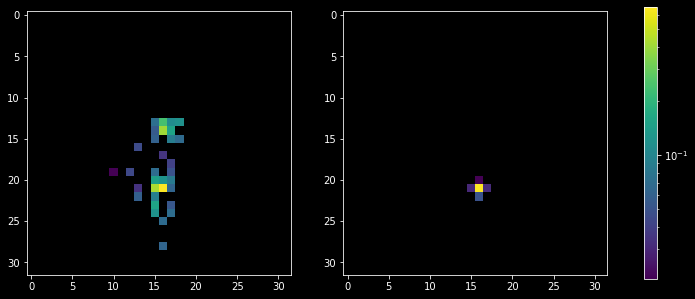

In [20]:
no=6
ch = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
for data, ax in zip([dataset['x_train'][no][:,:,ch], img[no][:,:,ch]], axes.flat):
    im = ax.imshow(data, norm=LogNorm())

fig.colorbar(im, ax=axes.ravel().tolist())

plt.show()

# plt.figure(figsize=(16,8))
# plt.subplot(1,2,1)
# plt.title('Background')
# im = plt.imshow(dataset['x_train'][no][:,:,ch])
# fig.colorbar(im)
# plt.subplot(1,2,2)
# plt.title('Reconstruction')
# plt.imshow(img[no][:,:,ch])
# plt.show()

In [ ]:
def reco_error(x):
    return np.square(np.log(pae.ae.predict(x)+1)-np.log(x+1))

def anomaly_score(x):
    """Calculates the anomaly scores for the input data"""
    sigma = np.mean(reco_error(dataset['x_valid']), axis=0)**(-1)
    mse = np.square(pae.ae.predict(x)-x)
    z = pae.ae.encode(x)
    byz = pae.nf.inverse(z)
    detJ = pae.nf.inverse_log_det_jacobian(z)
    ascore = -0.5*np.mean(mse*sigma, axis=(1,2,3)) - \
            0.5*np.linalg.norm(byz,axis=1)**2 + detJ
    return ascore



/tmp/ipykernel_217614/3648022588.py:1: RuntimeWarning:

divide by zero encountered in reciprocal



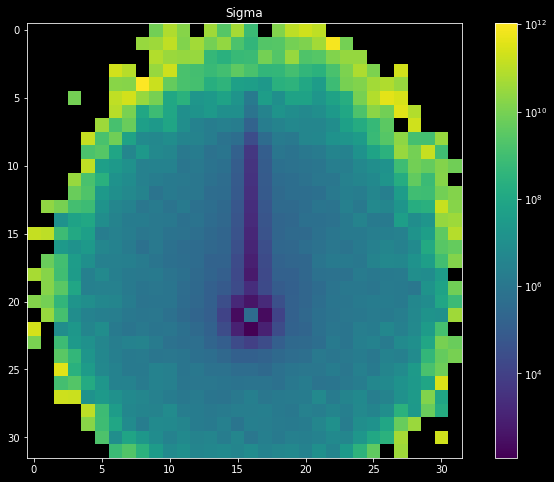

In [ ]:
sigma = np.mean(reco_error(dataset['x_valid']), axis=0)**(-1)
fig, ax = plt.subplots(figsize=(12,8))
plt.title('Sigma')
im = plt.imshow(sigma[:,:,0], norm=LogNorm())
fig.colorbar(im, ax=ax)
plt.show()

In [ ]:
with tf.device("/device:CPU:0"):
    sigma = np.mean(reco_error(dataset['x_valid']), axis = 0)**(-1)
    mse_test = reco_error(dataset['x_test'])
    test_mse = np.mean(mse_test*sigma, axis=(1,2,3))

    mse_train = reco_error(dataset['x_train'])
    train_mse = np.mean(mse_train*sigma, axis=(1,2,3))

/tmp/ipykernel_217614/601922952.py:2: RuntimeWarning:

divide by zero encountered in reciprocal

/tmp/ipykernel_217614/601922952.py:4: RuntimeWarning:

invalid value encountered in multiply

/tmp/ipykernel_217614/601922952.py:7: RuntimeWarning:

invalid value encountered in multiply



In [ ]:
with tf.device("/device:CPU:0"):
    test_ascore = -anomaly_score(dataset['x_test'])
    train_ascore = -anomaly_score(dataset['x_train'])

/tmp/ipykernel_217614/2240543605.py:6: RuntimeWarning:

divide by zero encountered in reciprocal

/tmp/ipykernel_217614/2240543605.py:11: RuntimeWarning:

invalid value encountered in multiply



/tmp/ipykernel_217614/2150305719.py:3: RuntimeWarning:

invalid value encountered in multiply

/tmp/ipykernel_217614/2150305719.py:5: RuntimeWarning:

invalid value encountered in multiply



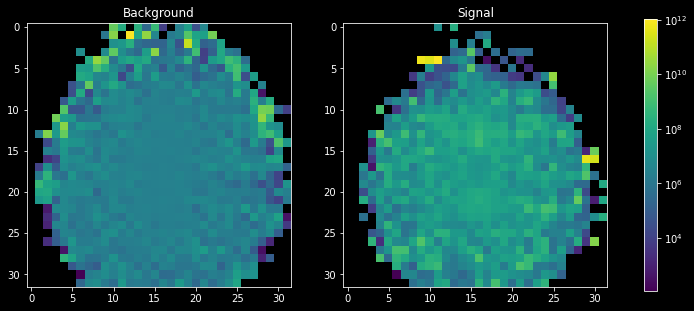

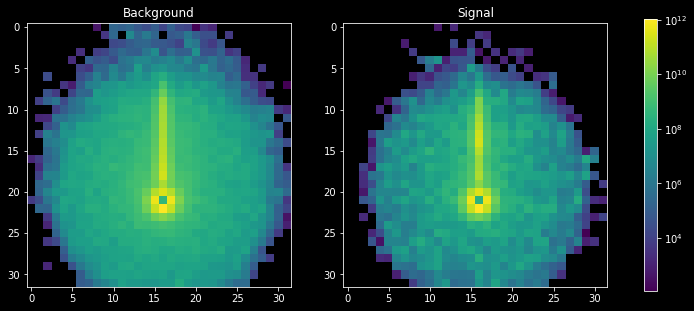

In [ ]:

fig, axes = plt.subplots(ncols=2, figsize=(13,5))
axes[0].set_title('Background')
axes[0].imshow(np.mean(mse_test[10_000:,:,:]*sigma, axis=0)[:,:,0], norm=LogNorm())
axes[1].set_title('Signal')
axes[1].imshow(np.mean(mse_test[:10_000,:,:]*sigma, axis=0)[:,:,0], norm=LogNorm())
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(13,5))
axes[0].set_title('Background')
axes[0].imshow(np.mean(mse_test[10_000:,:,:], axis=0)[:,:,0], norm=LogNorm())
axes[1].set_title('Signal')
axes[1].imshow(np.mean(mse_test[:10_000,:,:], axis=0)[:,:,0], norm=LogNorm())
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

/tmp/ipykernel_217614/116706140.py:3: RuntimeWarning:

invalid value encountered in multiply



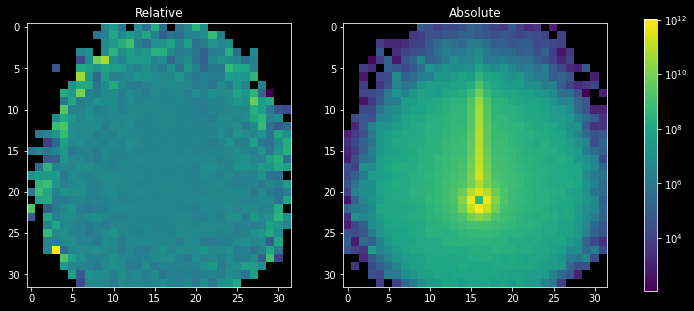

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(13,5))
axes[0].set_title('Relative')
axes[0].imshow(np.mean(mse_train*sigma, axis=0)[:,:,0], norm=LogNorm())
axes[1].set_title('Absolute')
axes[1].imshow(np.mean(mse_train, axis=0)[:,:,0], norm=LogNorm())
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

## Feature maps

(3, 3, 32, 64) (64,)


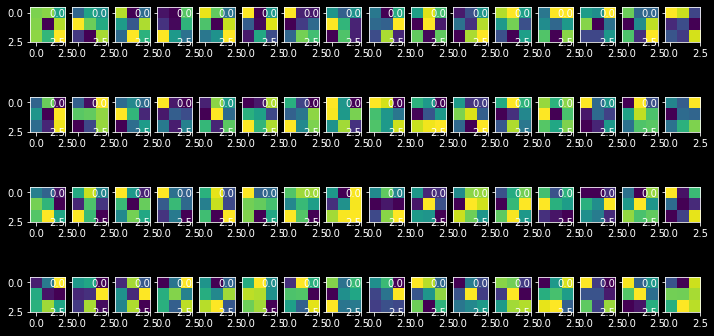

In [ ]:
lno = 2
fno = 2
cno = 0

filters, biases = pae.ae.encoder.layers[lno].get_weights()
print(filters.shape, biases.shape)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
plt.figure(figsize=(12,8))
for fno in range(filters.shape[-1]):
    plt.subplot(5, filters.shape[-1]//4, fno+1)
    f = filters[:, :, :, fno]
    plt.imshow(f[:, :, cno])
plt.show()

## Plots

In [ ]:
prc=95


fig = go.Figure()
fig.add_trace(go.Histogram(x=test_ascore[10_000:], name='Background', 
                           marker_color='steelblue', nbinsx=80),
             )
fig.add_trace(go.Histogram(x=test_ascore[:10_000], name='Signal', 
                           marker_color='darkorange', nbinsx=80),
             )


fig.update_layout(
    xaxis_title='Anomaly Score',
    title_text=r'Anomlay Score Distributions',
    barmode='stack',
    width=600)
fig.show('vscode')

In [ ]:
test_ascore

array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:
from scipy.spatial.distance import jensenshannon
pio.templates.default = "presentation"
mjj = dataset['mjj_train']
max_prc = 99
score = train_ascore
n_full, b = np.histogram(mjj, bins=60, density=True)
js_div = {}

for prc in range(1, max_prc+1):
    x_prc = np.percentile(score, prc)
    i_prc = np.where(score >= x_prc)[0]
    n_prc, _ = np.histogram(mjj[i_prc], bins=b, density=True)
    js_div[prc] = jensenshannon(n_full,n_prc)

score = train_mse
js_div_mse = {}
for prc in range(1, max_prc+1):
    x_prc = np.percentile(score, prc)
    i_prc = np.where(score >= x_prc)[0]
    n_prc, _ = np.histogram(mjj[i_prc], bins=b, density=True)
    js_div_mse[prc] = jensenshannon(n_full,n_prc)

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=list(js_div.keys()), y=list(js_div.values()), mode='lines',
        name="PAE ascore", line=dict(color="plum", width=3))
)
fig.add_trace(
    go.Scatter(x=list(js_div_mse.keys()), y=list(js_div_mse.values()), mode='lines',
        name="NMSE", line=dict(color="steelblue", width=3))
)


fig.update_layout(
    title_text = "Mass sculpting",
    xaxis_title = "Percentile Cut",
    yaxis_title = "Jensen–Shannon",
    margin={'l': 80, 'b': 40, 't': 40, 'r': 0},
    width=750, height=450

)
fig.show('vscode')
#fig.write_image("JS-plot.png")


/home/idinu/.conda/envs/tf-gpu/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide



In [ ]:
from sklearn.metrics import roc_curve, auc
import plotly.express as px

def binarize(label):
    return 1 if label == 'sig' else 0
labels = np.array(list(map(binarize, dataset['labels_test'])))
#labels = np.concatenate([np.ones(10_000),np.zeros(10_000)])

fpr, tpr, _ = roc_curve(labels, test_ascore)
pae_auc = auc(1-fpr, tpr)

fpr_mse, tpr_mse, _ = roc_curve(labels, test_mse)
nmse_auc = auc(1-fpr_mse, tpr_mse)

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=tpr, y=1-fpr, mode='lines',
        name=f"PAE (AUC:{pae_auc:.2f})", line=dict(color="Plum", width=2))
)
fig.add_trace(
    go.Scatter(x=tpr_mse, y=1-fpr_mse, mode='lines',
        name=f"NMSE (AUC:{nmse_auc:.2f})", line=dict(color="steelblue", width=2))
)

fig.update_layout(
    width=500, height=500,
    xaxis_title = "Signal efficiency",
    yaxis_title = "Background Rejection",
    margin={'l': 60, 'b': 60, 't': 40, 'r': 0},
    legend = dict(x=0.1, y=0.05,
        traceorder='normal',
        font=dict(size=15)),
    title_text="ROC curves"
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
#fig.write_image("ROC2jet.png")
fig.show('vscode')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
anomaly_score()